In [10]:
# -*- coding: utf-8 -*-


import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, FloatSlider
import argparse
import pandas as pd
import numpy as np
import SimpleITK as sitk
import DicomReader
import ResampleSegmentations
from myshow import myshow, myshow3d

In [11]:
filepath_segm_mask = r"C:\tmp_patients\Pat_MAV_BE_B02_\Study_0\Series_7\CAS-One Recordings\2019-09-05_11-52-19\Segmentations\SeriesNo_7\SegmentationNo_0"
filepath_source_img = r"C:\tmp_patients\Pat_MAV_BE_B02_\Study_0\Series_7"
mask = DicomReader.read_dcm_series(filepath_segm_mask, False)
img = DicomReader.read_dcm_series(filepath_source_img, False)
print('mask size:', mask.GetSize())
print('img size:', img.GetSize())

mask size: (35, 26, 30)
img size: (512, 512, 233)


New Resampled Mask Size (512, 512, 233)


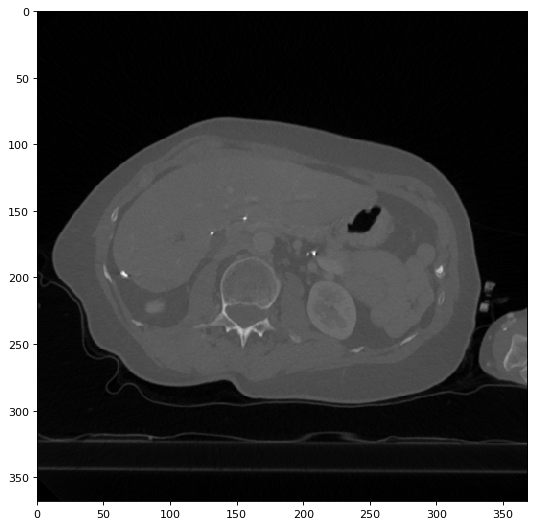

In [12]:
resizer = ResampleSegmentations.ResizeSegmentation(img, mask)
mask_resampled = resizer.resample_segmentation()
print('New Resampled Mask Size',  mask_resampled.GetSize())
# extract seeding point
# seeding point should be center of tumor
# apply smoothing
# extract the minimum value along the liver boundary
# extract the gradient in the object region
myshow3d(img)

In [13]:
stats = sitk.LabelStatisticsImageFilter()
print(stats.GetLabels())
print(stats.HasLabel(label=0))

stats.Execute(img, mask_resampled)

factor = 3.5
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
print(lower_threshold, upper_threshold)

()
False
0.0 0.0


In [14]:
stoppingValue = 1000
seedPosition = [325, 180, 137] # center of the tumor
timeThreshold = 1000
# seedValue = 0

# fastMarching = sitk.FastMarchingImageFilter()
fastMarching = sitk.FastMarchingBaseImageFilter()
trialPoint = (seedPosition[0], seedPosition[1], seedPosition[2])
fastMarching.AddTrialPoint(trialPoint)
fastMarching.SetStoppingValue(stoppingValue)
fastMarchingOutput = fastMarching.Execute(img)


thresholder = sitk.BinaryThresholdImageFilter()
thresholder.SetLowerThreshold(0.0)
thresholder.SetUpperThreshold(timeThreshold)
thresholder.SetOutsideValue(0)
thresholder.SetInsideValue(255)

result = thresholder.Execute(fastMarchingOutput)

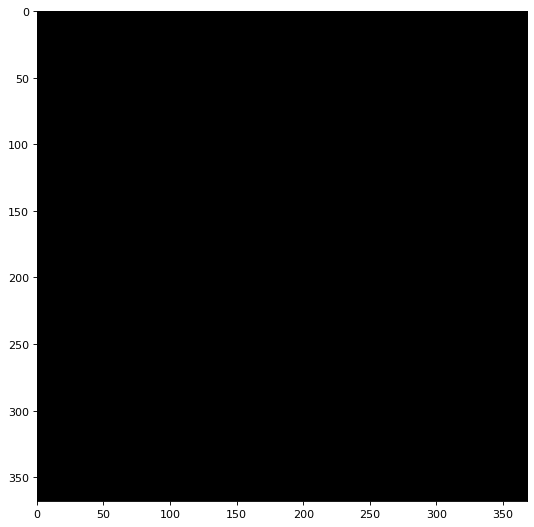

In [19]:
# myshow(mask_resampled)
myshow(result)

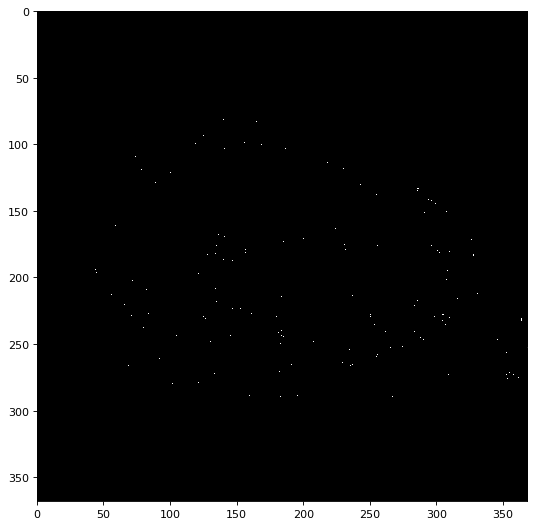

In [16]:
myshow(sitk.Threshold(fastMarchingOutput,
                    lower=0.0,
                    upper=fastMarching.GetStoppingValue(),
                    outsideValue=fastMarching.GetStoppingValue()+1))
# write result to disk I imagine

In [17]:
# def fm_callback(img, time, z):
#     seg = img<time;
#     myshow(sitk.LabelOverlay(img[:,:,z], seg[:,:,z]))
#            
# interact( lambda **kwargs: fm_callback(fastMarchingOutput, **kwargs),
#             time=FloatSlider(min=0.05, max=1000.0, step=0.05, value=100.0),
#             z=(0, fastMarchingOutput.GetSize()[2]-1))



In [18]:
# img = sitk.ReadImage("cthead1.png", sitk.sitkFloat32)
#
# fastMarching = sitk.FastMarchingBaseImageFilter()
# fastMarching.AddTrialPoint([160,190,0])
# radius = 10
# fastMarching.SetStoppingValue(radius+5)
# initial_ls = fastMarching.Execute(img*0+1)-radius
#
# lsFilter = sitk.ScalarChanAndVeseDenseLevelSetImageFilter()
# lsFilter.SetMaximumRMSError(0.0)
# lsFilter.SetNumberOfIterations(500)
# lsFilter.SetLambda1(1)
# lsFilter.SetLambda2(1)
# lsFilter.SetEpsilon(1.0)
# lsFilter.SetCurvatureWeight(1.0)
# lsFilter.SetAreaWeight(0.0)
# lsFilter.SetReinitializationSmoothingWeight(0.0)
# lsFilter.SetVolume(0.0)
# lsFilter.SetVolumeMatchingWeight(0.0)
# lsFilter.SetHeavisideStepFunction(lsFilter.AtanRegularizedHeaviside)
# output = lsFilter.Execute(initial_ls, img)
